# Tutorial1:cell-type annotation on scST data

We utilized MERFISH mouse hypothalamic data (ID=15) to test the annotation accuracy of STAMapper, the scST dataset with a manual annotation is provided. The scRNA-seq dataset and the scST dataset can be download from [Google Drive](https://drive.google.com/drive/folders/1xP3Fh94AwKu4OsH3khGq-KEw0VCoiRnL) (MERFISH_hypothalamic.zip). 

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
import os
import shutil
from STAMapper import pipeline, pp, pl
import warnings
warnings.filterwarnings("ignore")

In [2]:
key_class1 = 'celltype'#celltype label for adata_sc, stored in adata_sc.obs[key_class1]
key_class2 = 'celltype'#celltype label for adata_sp, stoted in adata_sp.obs[key_class2]
key_classes = [key_class1, key_class2]

## Load data

In [3]:
adata_sc = sc.read_h5ad(r'../data/hypothalamic_sc.h5ad')
adata_sp = sc.read_h5ad(r'../data/MERFISH_hypothalamic_15.h5ad') 

sc_name = 'hypothalamic_sc'
sp_name = 'hypothalamic_MERFISH'

#change dsnames for a new training task
dsnames = (sc_name, sp_name)

#delete dirs for old task with the same dsnames
if os.path.exists(Path(".") /'_temp' / f'{dsnames}'):
    shutil.rmtree(Path(".") /'_temp' / f'{dsnames}')

### Optional (filter low-quality genes and cells)

Make sure genes are set as var_index in adata_sc and adata_sp, otherwise you can use:

In [ ]:
#adata_sc.var.set_index('gene_name', inplace = True)

The filtering process is not used in this case (since they have been filtered in advance), but may be useful for other data.

In [ ]:
#sc.pp.filter_cells(adata_sc, min_genes=100)
#sc.pp.filter_genes(adata_sc, min_cells=3)

#sc.pp.filter_cells(adata_sp, min_genes=100)
#sc.pp.filter_genes(adata_sp, min_cells=3)

## Training

In [4]:
adatas = [adata_sc, adata_sp]
outputs = pipeline.training(adatas=adatas, dsnames=dsnames, key_classes=key_classes)

Data Preprocessing!
[leiden] Time used:  153.5468 s
a new directory made:
	_temp\('hypothalamic_sc', 'hypothalamic_MERFISH')\0\figs
already exists:
	_temp\('hypothalamic_sc', 'hypothalamic_MERFISH')\0
[*] Setting dataset names:
	0-->hypothalamic_sc
	1-->hypothalamic_MERFISH
[*] Setting aligned features for observation nodes (self._features)
[*] Setting observation-by-variable adjacent matrices (`self._ov_adjs`) for making merged graph adjacent matrix of observation and variable nodes
-------------------- Summary of the DGL-Heterograph --------------------
Graph(num_nodes={'cell': 48956, 'gene': 154},
      num_edges={('cell', 'express', 'gene'): 1451057, ('cell', 'self_loop_cell', 'cell'): 48956, ('cell', 'similar_to', 'cell'): 315474, ('gene', 'expressed_by', 'cell'): 1451057, ('gene', 'self_loop_gene', 'gene'): 154},
      metagraph=[('cell', 'gene', 'express'), ('cell', 'cell', 'self_loop_cell'), ('cell', 'cell', 'similar_to'), ('gene', 'cell', 'expressed_by'), ('gene', 'gene', 'sel

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 21.25it/s]


object saved into:
	 _temp\('hypothalamic_sc', 'hypothalamic_MERFISH')\0\datapair_init.pickle


## Check accuracy

In [5]:
folder_path = Path(".") /'_temp' / f'{dsnames}'
best_model, accuracy, macrof1, weightedf1 = pp.calc_scores(folder_path, key_class2)
print(f"Best Model: {best_model}, Accuracy: {accuracy:.3f}, Macro F1 Score: {macrof1:.3f}, Weighted F1 Score: {weightedf1:.3f}")

Best Model: 0, Accuracy: 0.869, Macro F1 Score: 0.596, Weighted F1 Score: 0.870


 ## Visualization

In [6]:
obs = pd.read_csv(folder_path/f'{best_model}'/'obs.csv',index_col=0)
obs = obs[obs['dataset'].isin([sp_name])]
adata_sp.obs['predicted'] = list(obs['predicted'])

In [7]:
sc.pp.normalize_total(adata_sp, target_sum=1e4)
sc.pp.log1p(adata_sp)
adata_sp.raw = adata_sp
#sc.pp.scale(adata_sp, max_value=10)#optional
sc.tl.pca(adata_sp, svd_solver="arpack")
sc.pp.neighbors(adata_sp, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_sp)

Compare maunal annotation(upper panel) with predicted (lower panel).

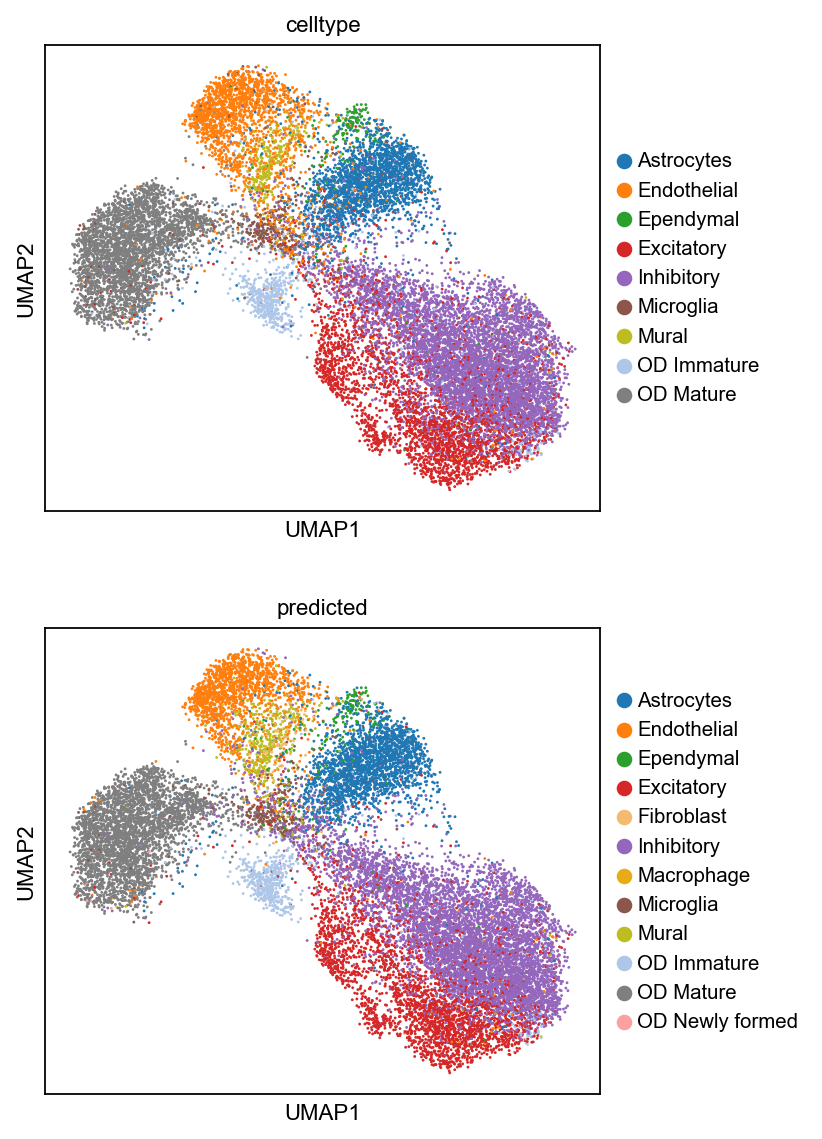

In [8]:
palette = {'Astrocytes': '#1f77b4',
 'Inhibitory': '#9467bd',
 'Endothelial': '#ff7f0e',
 'Ependymal': '#2ca02c',
 'Excitatory': '#d62728',
 'Fibroblast': '#f3bb70',
 'Macrophage': '#e7ac18',
 'Microglia': '#8c564b',
 'Mural': '#bcbd22',
 'OD Immature': '#aec7e8',
 'OD Mature': '#7f7f7f',
 'OD Newly formed': '#fda1a0'}

sc.pl.umap(adata_sp, color=["celltype", "predicted"], ncols=1, palette=palette)